In [1]:
import os
# import pandas as pd 
import polars as pl
# import scanpy as sc
import numpy as np
import typing as tp
import re
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
# from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import cross_validate, cross_val_score
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib inline
import os, shutil, glob
import seaborn as sns; sns.set_style("white")
import umap as umap
# import hdbscan as hdb

# import plotnine as gg
# from cytominer_eval import evaluate

os.getcwd()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/scratch2-shared/david/colopaint3D/python'

In [2]:
figformat = 'png'
dpi = 300
statarg = 'single'
OutputDir = f'./data/2_PCAUMAP'
if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)
feat_sc = './data/1_FeaturesImages_meanstd_PerPlate'
feat_agg = '/share/data/analyses/christa/colopaint3D/spher_colo52_v1'


In [3]:
# filenames = ['HCT116_MedianAgg_meanstd']
# filenames = 'selected_data_all_grit.csv'
# filenames = ['HCT116_MeanAgg_medianmad']
# filenames = ['HT29_MeanAgg_medianmad']
# filenames = ['HT29_MedianAgg_meanstd']
# statmet = 'SingleSlice'
# statmet = 'prototype'
# statmet = 'WellAggregates'
statmet = 'SingleCell'
# filenames = ['HCT116_MedianAgg_meanstd_prototype_slice_selected']
# filenames = ['HT29_mad']
# filenames = ['HT29_mean']
filenames = ['HCT116']
# filenames = ['HCT116_mean']
# filenames = ['HCT116_Slice3MeanAgg_medianmad']
# filenames = ['HCT116_Slice3MedianAgg_meanstd']
# filenames = ['HT29_Slice3MeanAgg_medianmad']
# filenames = ['HT29_Slice3MedianAgg_meanstd']
statmets = ['SingleCell']

dropcols = ['Nuclei_Location_Center_X',
            'Nuclei_Location_Center_Y',
            'Location',
            'ImageNumber_',
            'Parent',
            'Children',
            '_ObjectNumber',
            '_Object_Number',
            '_Y',
            '_X' 
            ]


cons = ['pos_con', 'neg_con']
nodmso = ['trt']
wdmso = ['pos_con']
float_columns=[pl.col(pl.Float32),pl.col(pl.Float64)]

##### Correlation contains some kind of well information
# feature_groups = ['AreaShape'
#                   , 'Correlation'
#                   , 'Granularity'
#                   , 'Intensity'
#                   , 'Neighbors'
#                   , 'RadialDistribution'
#                   ]
# real_names = [x for x in training_data.columns if x.split('_')[0] in feature_groups]
# training_data = training_data[real_names]

In [4]:
def readData(filename, statmet='SingleCell'):
    df = pl.read_parquet(f'{feat_sc}/{statmet}/{filename}.parquet')
    ##This here is important!!!!!!
    # df=df.select([c for c in df.columns if not is_meta_column(c)])
    # dataNpy = df.to_numpy(df.select(float_columns))
    ##
    onehot_list = df.select(['Metadata_cmpd_pathway'])['Metadata_cmpd_pathway'].unique().to_list()
    onehot_mapping = {name: i for i, name in enumerate(onehot_list)}
    df = df.with_columns(df['Metadata_cmpd_pathway'].map_elements(lambda name: oneHot(name, onehot_mapping)).alias('Metadata_cmpd_onehot'))
    return df

# this is code from Dan
def is_meta_column(
    c:str,
    allowlist:tp.List[str]=["Metadata_Well","Metadata_Barcode","Metadata_AcqID","Metadata_Site"],
    denylist:tp.List[str]=[],
)->bool:
    """
        allowlist:
            the function will return False for these, no matter if they are metadata or not
        denylist:
            the function will return True for these, no matter if they are metadata or not
    """
    if c in allowlist:
        return False
    if c in denylist:
        return True
    for ex in '''
        Metadata
        ^Count
        ImageNumber
        Object
        Parent
        Children
        Plate
        Well
        Location
        _[XYZ]_
        _[XYZ]$
        BoundingBox
        Phase
        Orientation
        Angle
        Scale
        Scaling
        Width
        Height
        Group
        FileName
        PathName
        URL
        Execution
        ModuleError
        LargeBrightArtefact
        MD5Digest
        RadialDistribution_Frac
        Intensity_
        _Manders
        _Overflow
    '''.split():
        if re.search(ex, c):
            return True
    return False


def oneHot(row, mapping):
    return mapping.get(row, -1)

def makePCA(df, name='', statmet='SingleCell' , n_components=2):
    dataN=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns).to_numpy()
    pca_model = PCA(n_components=2)
    pca_model = pca_model.fit(dataN)
    pcaOut = pca_model.transform(dataN)
    df = df.with_columns([
    pl.Series('pc1', pcaOut[:, 0]),  
    pl.Series('pc2', pcaOut[:, 1])   
    ])

    hue = df['Metadata_cmpd_pathway'].to_list()
    cmap = sns.color_palette("tab20", n_colors=len(df['Metadata_cmpd_pathway'].unique().to_list()))

    fig = plt.figure(
    # figsize=[14, 5]
    )
    ax = fig.add_subplot(111)
    ax.set_xlabel('PC 1', fontsize = 10)
    ax.set_ylabel('PC 2', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    sns.scatterplot(x=df['pc1'].to_list(),
                    y=df['pc2'].to_list(),
                    palette=cmap, hue=hue,
                    marker='.',
                    ).set(title=f'PCA {name} All'
                )
    ax.set_facecolor('w')
    ax.get_legend().remove()
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    plt.close()
    return df

def makeUMAP(df, name='', statmet='SingleCell' , nn = 200, is_supervised=True, n_components=100, min_dist=0.1, spread= 5, n_epochs=None, metric='cosine', use_pca=True):
    dataN=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns).to_numpy()
    umap_model = umap.UMAP(n_neighbors=nn
                        , min_dist=min_dist
                        , spread= spread
                        , n_epochs=n_epochs
                        , metric=metric
                        , n_jobs=-1
                        )
    if use_pca:
        pca_model = PCA(n_components=n_components)
        pca_model = pca_model.fit(dataN)
        dataN = pca_model.transform(dataN)
        
    if is_supervised:
        umapOut = umap_model.fit_transform(dataN, y=df['Metadata_cmpd_onehot'].to_list())
        isSup = 'Supervised'
    else:
        umapOut = umap_model.fit_transform(dataN)
        isSup = 'Unsupervised'
    df = df.with_columns([
    pl.Series('umap1', umapOut[:, 0]),  
    pl.Series('umap2', umapOut[:, 1])   
    ])

    hue = df['Metadata_cmpd_pathway'].to_list()
    cmap = sns.color_palette("tab20", n_colors=len(df['Metadata_cmpd_pathway'].unique().to_list()))

    fig = plt.figure(
    # figsize=[14, 5]
    )
    ax = fig.add_subplot(111)
    ax.set_xlabel('UMAP 1', fontsize = 10)
    ax.set_ylabel('UMAP 2', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    sns.scatterplot(x=df['umap1'].to_list(),
                    y=df['umap2'].to_list(),
                    palette=cmap, hue=hue,
                    marker='.',
                    ).set(title=f'umap {name} All'
                )
    ax.set_facecolor('w')
    ax.get_legend().remove()
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # if not os.path.exists(f'{OutputDir}/{statmet}'):
    #     os.makedirs(f'{OutputDir}/{statmet}')
    # plt.savefig(f'{OutputDir}/{statmet}/{name}_umap{nn}nn_{isSup}.png')
    plt.show()
    plt.close()
    return df


In [5]:
# df = pl.read_parquet(f'{feat_sc}/{statmet}/{filenames[0]}.parquet')
# df = pl.read_csv(f'{feat_agg}/{filenames}')
# num_rows_before_nan_trim = df.shape[0]
# for col in df.select([pl.col(pl.Float32),pl.col(pl.Float64)]).columns:
#     before_drop=df.shape[0]
#     df=df.filter(pl.col(col).is_not_null())
#     after_drop=df.shape[0]

#     num_values_dropped=before_drop-after_drop
#     if num_values_dropped>0:
#         print(f"dropped {num_values_dropped} rows due to NaNs in column {col}")

In [6]:
filename = filenames[0]
# df = pl.read_parquet(f'{FeatureDir}/SingleCell/{filename}.parquet')
df = readData(filename, statmet=statmet)
# df['Metadata_cmpd_pathway'].unique().to_list()

/tmp/ipykernel_335140/2642291150.py:9: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(df['Metadata_cmpd_pathway'].map_elements(lambda name: oneHot(name, onehot_mapping)).alias('Metadata_cmpd_onehot'))


In [7]:
df.head()

Cytoplasm_ImageNumber,Cytoplasm_ObjectNumber,Cytoplasm_Metadata_AcqID,Metadata_Barcode,Metadata_Site,Metadata_Well,Cytoplasm_FileName_CONC,Cytoplasm_FileName_HOECHST,Cytoplasm_FileName_MITO,Cytoplasm_FileName_PHAandWGA,Cytoplasm_FileName_SYTO,Cytoplasm_PathName_CONC,Cytoplasm_PathName_HOECHST,Cytoplasm_PathName_MITO,Cytoplasm_PathName_PHAandWGA,Cytoplasm_PathName_SYTO,Cytoplasm_AreaShape_Area,Cytoplasm_AreaShape_BoundingBoxArea,Cytoplasm_AreaShape_BoundingBoxMaximum_X,Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Cytoplasm_AreaShape_BoundingBoxMinimum_X,Cytoplasm_AreaShape_BoundingBoxMinimum_Y,Cytoplasm_AreaShape_Center_X,Cytoplasm_AreaShape_Center_Y,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_ConvexArea,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_EquivalentDiameter,Cytoplasm_AreaShape_EulerNumber,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MaxFeretDiameter,Cytoplasm_AreaShape_MaximumRadius,Cytoplasm_AreaShape_MeanRadius,Cytoplasm_AreaShape_MedianRadius,Cytoplasm_AreaShape_MinFeretDiameter,…,Cells_RadialDistribution_ZernikePhase_SYTO_3_3,Cells_RadialDistribution_ZernikePhase_SYTO_4_0,Cells_RadialDistribution_ZernikePhase_SYTO_4_2,Cells_RadialDistribution_ZernikePhase_SYTO_4_4,Cells_RadialDistribution_ZernikePhase_SYTO_5_1,Cells_RadialDistribution_ZernikePhase_SYTO_5_3,Cells_RadialDistribution_ZernikePhase_SYTO_5_5,Cells_RadialDistribution_ZernikePhase_SYTO_6_0,Cells_RadialDistribution_ZernikePhase_SYTO_6_2,Cells_RadialDistribution_ZernikePhase_SYTO_6_4,Cells_RadialDistribution_ZernikePhase_SYTO_6_6,Cells_RadialDistribution_ZernikePhase_SYTO_7_1,Cells_RadialDistribution_ZernikePhase_SYTO_7_3,Cells_RadialDistribution_ZernikePhase_SYTO_7_5,Cells_RadialDistribution_ZernikePhase_SYTO_7_7,Cells_RadialDistribution_ZernikePhase_SYTO_8_0,Cells_RadialDistribution_ZernikePhase_SYTO_8_2,Cells_RadialDistribution_ZernikePhase_SYTO_8_4,Cells_RadialDistribution_ZernikePhase_SYTO_8_6,Cells_RadialDistribution_ZernikePhase_SYTO_8_8,Cells_RadialDistribution_ZernikePhase_SYTO_9_1,Cells_RadialDistribution_ZernikePhase_SYTO_9_3,Cells_RadialDistribution_ZernikePhase_SYTO_9_5,Cells_RadialDistribution_ZernikePhase_SYTO_9_7,Cells_RadialDistribution_ZernikePhase_SYTO_9_9,Metadata_cmpd_image_id,Metadata_cmpd_cp_id,Metadata_cmpd_barcode,Metadata_cmpd_plate_well,Metadata_cmpd_cmpdname,Metadata_cmpd_pert_type,Metadata_cmpd_target,Metadata_cmpd_pathway,Metadata_cmpd_target_type,Metadata_cmpd_cell_line,Metadata_PlateWell,Metadata_cmpd_onehot
i32,i32,i32,str,i32,str,str,str,str,str,str,str,str,str,str,str,i32,i32,i32,i32,i32,i32,f32,f32,f32,i32,f32,f32,i32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i64,i64,str,str,str,str,str,str,str,str,str,i64
1,1,4189,"""PB000140""",0,"""D12""","""Well-D12-z0-CONC.ome.tiff""","""Well-D12-z0-HOECHST.ome.tiff""","""Well-D12-z0-MITO.ome.tiff""","""Well-D12-z0-PHAandWGA.ome.tiff""","""Well-D12-z0-SYTO.ome.tiff""","""/share/mikro2/nikon/spher-colo…","""/share/mikro2/nikon/spher-colo…","""/share/mikro2/nikon/spher-colo…","""/share/mikro2/nikon/spher-colo…","""/share/mikro2/nikon/spher-colo…",2817,4002,628,596,559,538,593.123169,565.946411,1.168473,2882,0.656623,59.889194,1,0.703898,0.855818,69.166962,70.774292,25.806976,9.6373,8.544003,52.057999,…,2.606187,-1.570796,-0.755269,2.573452,-1.145947,-0.485282,2.495228,-1.570796,2.477057,-2.536972,0.576231,-1.467601,2.862211,-1.345047,-2.044061,1.570796,2.157015,-0.699397,0.374318,-1.365559,2.013489,2.715371,-1.033808,0.098136,2.063111,4189,5573,"""PB000140""","""PB000140_D12""","""Encorafenib (LGX818)""","""trt""","""Raf""","""MAPK""","""Targeted""","""HCT116""","""PB000140_D12""",6
1,2,4189,"""PB000140""",0,"""D12""","""Well-D12-z0-CONC.ome.tiff""","""Well-D12-z0-HOECHST.ome.tiff""","""Well-D12-z0-MITO.ome.tiff""","""Well-D12-z0-PHAandWGA.ome.tiff""","""Well-D12-z0-SYTO.ome.tiff""","""/share/mikro2/nikon/spher-colo

In [8]:
# columns_containing_metadata = [col_name for col_name in df.columns if 'Metadata_' in col_name]
# columns_containing_metadata
# df2=df.select([c for c in df.columns if not is_meta_column(c)])
df_floats=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns)

# for c in df.columns:
#     if is_meta_column(c):
#         print(c)


In [9]:
# df2 = df.filter(pl.col('Metadata_cmpd_pert_type').is_in(cons))
# cons = ['pos_con']

df2 = df.filter(pl.col('Metadata_cmpd_pert_type').is_in(cons))
df3 = df.filter(pl.col('Metadata_cmpd_pert_type').is_in(nodmso))
df4 = df.filter(~pl.col('Metadata_cmpd_pert_type').is_in(wdmso))

In [10]:
df.select(pl.col('Metadata_cmpd_pert_type')).to_series().unique()

Metadata_cmpd_pert_type
str
"""pos_con"""
"""neg_con"""
"""trt"""


In [11]:
df2.shape[0]

111856

In [12]:
df3.shape[0]

761694

In [13]:
df4.shape[0]

854354

In [14]:
num_dmso = df2.filter(pl.col('Metadata_cmpd_pathway')== 'dmso').shape[0]
num_dmso = int(num_dmso*0.1)
print(num_dmso)
dmso_df = df2.filter(pl.col('Metadata_cmpd_pathway')=='dmso').sample(n=num_dmso, seed = 42)

df5 = df2.filter(~pl.col('Metadata_cmpd_pathway').is_in(['dmso']))

df5 = pl.concat([df5, dmso_df])
# df_with_id = df.with_column(pl.arange(0, df.height).alias('unique_id'))
# mask = pl.col('Metadata_cmpd_pathway').is_not('dmso') | df.join(dmso_rows, on=list(df.columns), how='inner').with_column(pl.lit(True).alias('keep'))

# print(df5.shape)
cols = df5['Metadata_cmpd_pathway'].unique().to_list()
for column in cols:
    # print(column)
    print(f"{column}:   {df5.filter(pl.col('Metadata_cmpd_pathway')==column).shape[0]}")

8256
dmso:   8256
stau:   4701
sorb:   7068
water:   10094
etop:   3319
fenb:   4108


In [15]:
cols = df3['Metadata_cmpd_pathway'].unique().to_list()
for column in cols:
    # print(column)
    print(f"{column}:   {df3.filter(pl.col('Metadata_cmpd_pathway')==column).shape[0]}")

Cytoskeletal Signaling:   28886
DNA Damage:   108713
Angiogenesis:   19228
Epigenetics:   11913
Proteases:   5486
JAK/STAT:   22218
Others:   18145
Apoptosis:   66326
TGF-beta/Smad:   21452
Cell Cycle:   61120
MAPK:   117632
Protein Tyrosine Kinase:   115526
Stem Cells & Wnt:   22848
PI3K/Akt/mTOR:   142201


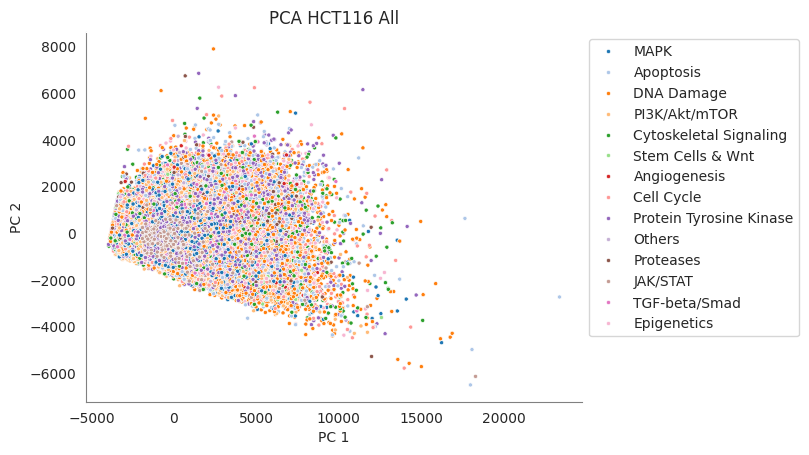

: 

In [16]:
_ = makePCA(df3, name=filename)
# df2 = makeUMAP(df2, name=filename, is_supervised=False, use_pca=False)


In [22]:
_ = makeUMAP(df3, name=filename, nn=100, is_supervised=False, use_pca=False)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [ ]:
_ = makeUMAP(df3, name=filename, nn=100, is_supervised=True, use_pca=False)